# Transfer Learning

In this notebook, we describe how we used fast.ai to apply transfer learning to the _De Boer_ Photo Collection

In [1]:
from fastai.vision.all import *
import torchvision.models as models
from fastai.callback.all import *
from torch.distributions.beta import Beta
from IPython.display import set_matplotlib_formats
from matplotlib import rc

In [466]:
# set matplotlib settings

rc('font', **{'family': 'serif', 'serif': ['Palatino']})
set_matplotlib_formats('retina', quality=100)

In [2]:
# implement cutmix
class CutMix(Callback):
    "Implementation of `https://arxiv.org/abs/1905.04899`"
    run_after,run_valid = [Normalize],False
    def __init__(self, alpha=1.): self.distrib = Beta(tensor(alpha), tensor(alpha))
    def before_fit(self):
        self.stack_y = getattr(self.learn.loss_func, 'y_int', False)
        if self.stack_y: self.old_lf,self.learn.loss_func = self.learn.loss_func,self.lf

    def after_fit(self):
        if self.stack_y: self.learn.loss_func = self.old_lf

    def before_batch(self):
        W, H = self.xb[0].size(3), self.xb[0].size(2)
        lam = self.distrib.sample((1,)).squeeze().to(self.x.device)
        lam = torch.stack([lam, 1-lam])
        self.lam = lam.max()
        shuffle = torch.randperm(self.y.size(0)).to(self.x.device)
        xb1,self.yb1 = tuple(L(self.xb).itemgot(shuffle)),tuple(L(self.yb).itemgot(shuffle))
        nx_dims = len(self.x.size())
        x1, y1, x2, y2 = self.rand_bbox(W, H, self.lam)
        self.learn.xb[0][:, :, x1:x2, y1:y2] = xb1[0][:, :, x1:x2, y1:y2]
        self.lam = (1 - ((x2-x1)*(y2-y1))/float(W*H)).item()

        if not self.stack_y:
            ny_dims = len(self.y.size())
            self.learn.yb = tuple(L(self.yb1,self.yb).map_zip(torch.lerp,weight=unsqueeze(self.lam, n=ny_dims-1)))

    def lf(self, pred, *yb):
        if not self.training: return self.old_lf(pred, *yb)
        with NoneReduce(self.old_lf) as lf:
            loss = torch.lerp(lf(pred,*self.yb1), lf(pred,*yb), self.lam)
        return reduce_loss(loss, getattr(self.old_lf, 'reduction', 'mean'))

    def rand_bbox(self, W, H, lam):
        cut_rat = torch.sqrt(1. - lam)
        cut_w = (W * cut_rat).type(torch.long)
        cut_h = (H * cut_rat).type(torch.long)
        # uniform
        cx = torch.randint(0, W, (1,)).to(self.x.device)
        cy = torch.randint(0, H, (1,)).to(self.x.device)
        x1 = torch.clamp(cx - cut_w // 2, 0, W)
        y1 = torch.clamp(cy - cut_h // 2, 0, H)
        x2 = torch.clamp(cx + cut_w // 2, 0, W)
        y2 = torch.clamp(cy + cut_h // 2, 0, H)
        return x1, y1, x2, y2

In [3]:
# helper functions for fast.ai

# def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
#     x = torch.linspace(min,max)
#     fig,ax = plt.subplots(figsize=figsize)
#     ax.plot(x,f(x))
#     if tx is not None: ax.set_xlabel(tx)
#     if ty is not None: ax.set_ylabel(ty)
#     if title is not None: ax.set_title(title)
        
        
def label_func(fname):
    '''
    function to grab folder name as label name
    '''
    return fname.parent.name

def get_dls(bs, size, augment=True):
    '''
    function to get datablocks
    '''
    if augment:
        batch_tfms=[*aug_transforms(size=size, 
                                    do_flip=True, 
                                    max_rotate = 10.0, 
                                    max_zoom=1.1, 
                                    min_scale=0.75), 
                    Normalize.from_stats(*imagenet_stats)]
    else:
        batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)]
        
    dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                       get_items=get_image_files, 
                       splitter=RandomSplitter(seed=42),
                       get_y=label_func,
                       item_tfms=Resize(460),
                       batch_tfms=batch_tfms)
    return dblock.dataloaders(path, bs=128)


def new_resnet(pretrained):
    '''
    fix for cnn_learner module using non-standard pre-trained models
    '''
    return default_res50

def accuracy_topk(output, target, topk=(3,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def random_test_image(img_dir, categories):
    """Pick a random test image from specified dir"""
    c = np.random.choice(categories)
    root = img_dir + c + '/'
    img_path = root + np.random.choice(os.listdir(root))
    print(img_path)
    return img_path

# Setting Paths

In [4]:
# setting path variables 
Path.BASE_PATH = Path('../projects/hisvis/src/output20/train/')
Path.BASE_PATH.ls()
path = Path.BASE_PATH

In [6]:
# fnames = get_image_files(path)
# dblock = DataBlock()
# dsets = dblock.datasets(fnames)
# dsets.train[0]
# dblock = DataBlock(get_items = get_image_files)

In [7]:
# dblock = DataBlock(get_items = get_image_files)
# dsets = dblock.datasets(path)
# dsets.train[0]

In [8]:
# dblock = DataBlock(get_items = get_image_files,
#                    get_y     = label_func)

# dsets = dblock.datasets(path)
# dsets.train[0]

In [9]:
#dls.show_batch(nrows=1, ncols=3)

## Initiate architecture

We load a resnet50 with weights trained on the places365 data set. 

In [10]:
# th architecture to use
arch = 'resnet50'

# (down)load the pre-trained weights
model_weights = '%s_places365.pth.tar' % arch
if not os.access(model_weights, os.W_OK):
    weight_url = 'http://places2.csail.mit.edu/models_places365/' + model_weights
    os.system('wget ' + weight_url)
    
places_res50 = torch.load(model_weights,  
                          map_location=lambda storage, 
                          loc: storage)

default_res50 = models.resnet50()
state_dict = places_res50['state_dict'] 
new_state_dict = OrderedDict()

for key in state_dict.keys():
    new_state_dict[key[7:]]= state_dict[key]
    

default_res50.fc = torch.nn.Linear(2048, 365) # Matching with default res50 dense layer
default_res50.load_state_dict(new_state_dict)

## Transfer Learning

### Baseline

In [146]:
learn = cnn_learner(get_dls(128, 224, augment=True), 
                    new_resnet, 
                    metrics=[top_k_accuracy, 
                             accuracy,
                             error_rate])

learn.fit_one_cycle(50, 3e-3, cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='deboer_baseline'), 
                                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,top_k_accuracy,accuracy,error_rate,time
0,3.905303,2.329133,0.727177,0.459601,0.540399,01:12
1,2.648951,1.745588,0.812172,0.567156,0.432844,01:12
2,2.029043,1.566237,0.851521,0.596013,0.403987,01:12
3,1.666074,1.499464,0.859391,0.598111,0.401889,01:12
4,1.456287,1.471784,0.875131,0.615425,0.384575,01:12
5,1.340211,1.549697,0.856243,0.607030,0.392970,01:13
6,1.240372,1.549248,0.868835,0.614900,0.385100,01:12
7,1.177381,1.669898,0.854145,0.590766,0.409234,01:12
8,1.168990,1.672030,0.847849,0.596013,0.403987,01:12
9,1.151574,1.695125,0.851521,0.575026,0.424974,01:12


Better model found at epoch 0 with valid_loss value: 2.3291327953338623.
Better model found at epoch 1 with valid_loss value: 1.745587944984436.
Better model found at epoch 2 with valid_loss value: 1.5662370920181274.
Better model found at epoch 3 with valid_loss value: 1.4994637966156006.
Better model found at epoch 4 with valid_loss value: 1.4717844724655151.
No improvement since epoch 4: early stopping


After epoch 2, the model starts to overfit, i.e. trainloss < valid_loss

### Label Smoothing

In [147]:
learn = cnn_learner(get_dls(128, 224, augment=True), new_resnet, loss_func=LabelSmoothingCrossEntropy(), 
                metrics=[error_rate, accuracy, top_k_accuracy])

learn.fit_one_cycle(50, 3e-3, cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='deboer_smoothing'),
                                  EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.162203,2.720183,0.522036,0.477964,0.744491,01:12
1,3.156175,2.368765,0.429171,0.570829,0.826863,01:13
2,2.653287,2.263396,0.407135,0.592865,0.851521,01:13
3,2.376684,2.211150,0.386149,0.613851,0.871459,01:13
4,2.231008,2.201427,0.396642,0.603358,0.865163,01:12
5,2.127499,2.190784,0.388248,0.611752,0.866737,01:12
6,2.039730,2.250681,0.410808,0.589192,0.847849,01:13
7,1.988119,2.237461,0.401364,0.598636,0.858342,01:12
8,1.940810,2.223448,0.403987,0.596013,0.863064,01:12
9,1.926921,2.243853,0.412382,0.587618,0.846800,01:12


Better model found at epoch 0 with valid_loss value: 2.7201826572418213.
Better model found at epoch 1 with valid_loss value: 2.368765354156494.
Better model found at epoch 2 with valid_loss value: 2.2633962631225586.
Better model found at epoch 3 with valid_loss value: 2.2111496925354004.
Better model found at epoch 4 with valid_loss value: 2.2014265060424805.
Better model found at epoch 5 with valid_loss value: 2.190784454345703.
No improvement since epoch 5: early stopping


### MixUp

In [148]:
mixup = MixUp(0.3)

learn = cnn_learner(get_dls(128, 224, augment=True), new_resnet, metrics=[error_rate, accuracy, top_k_accuracy], cbs=mixup)
learn.fit_one_cycle(50, 3e-3,  cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='mixup_0.3_aug'),
                                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])



epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.420274,2.378952,0.546695,0.453305,0.712487,01:12
1,3.442049,1.812408,0.448059,0.551941,0.806925,01:12
2,2.940236,1.597648,0.409759,0.590241,0.842078,01:12
3,2.678493,1.573734,0.401889,0.598111,0.855194,01:13
4,2.490960,1.561461,0.398741,0.601259,0.859916,01:12
5,2.376403,1.532150,0.392445,0.607555,0.865687,01:12
6,2.341299,1.530660,0.400839,0.599161,0.863064,01:13
7,2.257572,1.549633,0.406086,0.593914,0.856243,01:13
8,2.219079,1.592352,0.411333,0.588667,0.849948,01:13
9,2.192083,1.613047,0.409234,0.590766,0.842602,01:13


Better model found at epoch 0 with valid_loss value: 2.3789520263671875.
Better model found at epoch 1 with valid_loss value: 1.8124078512191772.
Better model found at epoch 2 with valid_loss value: 1.5976476669311523.
Better model found at epoch 3 with valid_loss value: 1.5737340450286865.
Better model found at epoch 4 with valid_loss value: 1.5614606142044067.
Better model found at epoch 5 with valid_loss value: 1.5321499109268188.
Better model found at epoch 6 with valid_loss value: 1.5306600332260132.
No improvement since epoch 5: early stopping


In [160]:
mixup = MixUp(0.3)

learn = cnn_learner(get_dls(128, 224, augment=False), new_resnet, metrics=[error_rate, accuracy, top_k_accuracy], cbs=mixup)
learn.fit_one_cycle(50, 3e-3,  cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='mixup_0.3_no_aug'),
                                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])



epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.553868,2.585443,0.596537,0.403463,0.671564,01:13
1,3.448918,1.851961,0.448583,0.551417,0.807975,01:13
2,2.788712,1.631697,0.401364,0.598636,0.848898,01:13
3,2.439696,1.527876,0.380902,0.619098,0.861490,01:13
4,2.172359,1.521044,0.381427,0.618573,0.875656,01:13
5,2.034151,1.522028,0.363064,0.636936,0.874082,01:13
6,1.983766,1.500172,0.371459,0.628541,0.874606,01:13
7,1.922387,1.586864,0.380902,0.619098,0.871983,01:13
8,1.864548,1.537772,0.380378,0.619622,0.866212,01:12
9,1.857485,1.524837,0.375656,0.624344,0.855719,01:13


Better model found at epoch 0 with valid_loss value: 2.585442543029785.
Better model found at epoch 1 with valid_loss value: 1.8519607782363892.
Better model found at epoch 2 with valid_loss value: 1.6316972970962524.
Better model found at epoch 3 with valid_loss value: 1.5278760194778442.
Better model found at epoch 4 with valid_loss value: 1.5210436582565308.
Better model found at epoch 6 with valid_loss value: 1.5001715421676636.
No improvement since epoch 6: early stopping


In [149]:
mixup = MixUp(0.3)

learn = cnn_learner(get_dls(128, 224, augment=True), new_resnet, loss_func=LabelSmoothingCrossEntropy(), metrics=[error_rate, accuracy, top_k_accuracy], cbs=mixup)
learn.fit_one_cycle(50, 3e-3,  cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='mixup_0.3_smoothing'),
                                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.624891,2.837041,0.538300,0.461700,0.715110,01:12
1,3.836147,2.414450,0.431794,0.568206,0.816894,01:13
2,3.408203,2.300332,0.411857,0.588143,0.843652,01:12
3,3.173943,2.267663,0.411333,0.588667,0.855719,01:13
4,3.011365,2.242575,0.402413,0.597587,0.849948,01:13
5,2.880172,2.255484,0.422350,0.577650,0.858867,01:12
6,2.837445,2.200804,0.399265,0.600735,0.856768,01:13
7,2.769200,2.148332,0.392970,0.607030,0.858867,01:12
8,2.711947,2.191593,0.399265,0.600735,0.853620,01:13
9,2.674062,2.174185,0.396118,0.603882,0.861490,01:12


Better model found at epoch 0 with valid_loss value: 2.837040662765503.
Better model found at epoch 1 with valid_loss value: 2.414449691772461.
Better model found at epoch 2 with valid_loss value: 2.3003318309783936.
Better model found at epoch 3 with valid_loss value: 2.2676634788513184.
Better model found at epoch 4 with valid_loss value: 2.242574691772461.
Better model found at epoch 6 with valid_loss value: 2.2008044719696045.
Better model found at epoch 7 with valid_loss value: 2.148331880569458.
No improvement since epoch 7: early stopping


In [150]:
mixup = MixUp(0.4)

learn = cnn_learner(get_dls(128, 224, augment=True), new_resnet, metrics=[error_rate, accuracy, top_k_accuracy], cbs=mixup)
learn.fit_one_cycle(50, 3e-3,  cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='mixup_0.4'),
                                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.407527,2.291439,0.525184,0.474816,0.725079,01:12
1,3.482536,1.780200,0.440714,0.559286,0.818993,01:13
2,3.021662,1.599663,0.408185,0.591815,0.846800,01:13
3,2.764178,1.560829,0.398741,0.601259,0.851521,01:12
4,2.626980,1.576595,0.405037,0.594963,0.860441,01:13
5,2.548519,1.529599,0.389297,0.610703,0.860441,01:12
6,2.425777,1.545441,0.406086,0.593914,0.855719,01:12
7,2.399481,1.581013,0.407135,0.592865,0.853095,01:13
8,2.373534,1.605331,0.415530,0.584470,0.846275,01:13
9,2.346837,1.675829,0.434942,0.565058,0.846800,01:12


Better model found at epoch 0 with valid_loss value: 2.2914388179779053.
Better model found at epoch 1 with valid_loss value: 1.780200481414795.
Better model found at epoch 2 with valid_loss value: 1.599663257598877.
Better model found at epoch 3 with valid_loss value: 1.5608294010162354.
Better model found at epoch 5 with valid_loss value: 1.5295989513397217.
No improvement since epoch 5: early stopping


In [159]:
mixup = MixUp(0.4)

learn = cnn_learner(get_dls(128, 224, augment=False), new_resnet, metrics=[error_rate, accuracy, top_k_accuracy], cbs=mixup)
learn.fit_one_cycle(50, 3e-3,  cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='mixup_no_aug_0.4'),
                                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.508543,2.519873,0.570829,0.429171,0.680483,01:12
1,3.544950,1.866297,0.433368,0.566632,0.810073,01:13
2,2.972716,1.610921,0.395593,0.604407,0.856243,01:12
3,2.648659,1.567427,0.388772,0.611228,0.858867,01:12
4,2.447043,1.544867,0.390871,0.609129,0.864113,01:13
5,2.310538,1.538238,0.375131,0.624869,0.866737,01:12
6,2.218501,1.518103,0.371983,0.628017,0.868311,01:13
7,2.176023,1.541418,0.378804,0.621196,0.874082,01:13
8,2.128427,1.584264,0.393494,0.606506,0.860441,01:13
9,2.092503,1.521683,0.375656,0.624344,0.860965,01:14


Better model found at epoch 0 with valid_loss value: 2.5198729038238525.
Better model found at epoch 1 with valid_loss value: 1.8662974834442139.
Better model found at epoch 2 with valid_loss value: 1.610920786857605.
Better model found at epoch 3 with valid_loss value: 1.5674270391464233.
Better model found at epoch 4 with valid_loss value: 1.5448673963546753.
Better model found at epoch 5 with valid_loss value: 1.5382376909255981.
Better model found at epoch 6 with valid_loss value: 1.5181028842926025.
Better model found at epoch 11 with valid_loss value: 1.4878422021865845.
Better model found at epoch 15 with valid_loss value: 1.4816685914993286.
Better model found at epoch 16 with valid_loss value: 1.4324299097061157.
Better model found at epoch 19 with valid_loss value: 1.420459508895874.
Better model found at epoch 20 with valid_loss value: 1.4188580513000488.
Better model found at epoch 21 with valid_loss value: 1.3833422660827637.
Better model found at epoch 22 with valid_loss 

In [151]:
mixup = MixUp(0.4)

learn = cnn_learner(get_dls(128, 224, augment=True), new_resnet, loss_func=LabelSmoothingCrossEntropy(), 
                    metrics=[error_rate, accuracy, top_k_accuracy], cbs=mixup)
learn.fit_one_cycle(50, 3e-3,  cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='mixup_0.4_smoothing'),
                                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.644249,2.809509,0.538825,0.461175,0.724029,01:12
1,3.898777,2.430871,0.442288,0.557712,0.816369,01:13
2,3.490820,2.328171,0.422350,0.577650,0.844176,01:13
3,3.289186,2.313479,0.405037,0.594963,0.844176,01:13
4,3.141626,2.205316,0.399265,0.600735,0.857293,01:13
5,3.029891,2.248577,0.398741,0.601259,0.852571,01:13
6,2.920210,2.209952,0.408185,0.591815,0.855719,01:12
7,2.878140,2.217819,0.400839,0.599161,0.856768,01:13
8,2.837807,2.192902,0.403463,0.596537,0.855719,01:13
9,2.786658,2.141433,0.408185,0.591815,0.857293,01:12


Better model found at epoch 0 with valid_loss value: 2.809509038925171.
Better model found at epoch 1 with valid_loss value: 2.430870771408081.
Better model found at epoch 2 with valid_loss value: 2.3281712532043457.
Better model found at epoch 3 with valid_loss value: 2.313478708267212.
Better model found at epoch 4 with valid_loss value: 2.2053163051605225.
Better model found at epoch 8 with valid_loss value: 2.192902088165283.
Better model found at epoch 9 with valid_loss value: 2.1414332389831543.
Better model found at epoch 14 with valid_loss value: 2.0955922603607178.
Better model found at epoch 15 with valid_loss value: 2.0824310779571533.
Better model found at epoch 17 with valid_loss value: 2.0550291538238525.
Better model found at epoch 20 with valid_loss value: 2.0132429599761963.
Better model found at epoch 22 with valid_loss value: 2.0090818405151367.
Better model found at epoch 23 with valid_loss value: 2.0041463375091553.
Better model found at epoch 24 with valid_loss va

In [25]:
mixup = MixUp(0.4)

learn = cnn_learner(get_dls(128, 224, augment=False), new_resnet, loss_func=LabelSmoothingCrossEntropy(), 
                    metrics=[error_rate, accuracy, top_k_accuracy], cbs=mixup)
learn.fit_one_cycle(50, 3e-3,  cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='mixup_0.4_no_aug_smoothing'),
                                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.892766,2.958912,0.583421,0.416579,0.673137,01:12
1,4.034268,2.457762,0.458552,0.541448,0.806925,01:12
2,3.552714,2.320575,0.415005,0.584995,0.842078,01:12
3,3.288071,2.228105,0.395068,0.604932,0.857293,01:12
4,3.084311,2.211107,0.381952,0.618048,0.859391,01:12
5,2.955384,2.197741,0.387723,0.612277,0.861490,01:12
6,2.833461,2.179739,0.391920,0.608080,0.866212,01:12
7,2.753958,2.134967,0.378279,0.621721,0.866212,01:12
8,2.697273,2.118764,0.371459,0.628541,0.868311,01:12
9,2.667894,2.108422,0.385624,0.614376,0.879853,01:12


Better model found at epoch 0 with valid_loss value: 2.9589123725891113.
Better model found at epoch 1 with valid_loss value: 2.457761764526367.
Better model found at epoch 2 with valid_loss value: 2.3205745220184326.
Better model found at epoch 3 with valid_loss value: 2.228105068206787.
Better model found at epoch 4 with valid_loss value: 2.211106538772583.
Better model found at epoch 5 with valid_loss value: 2.1977407932281494.
Better model found at epoch 6 with valid_loss value: 2.179739475250244.
Better model found at epoch 7 with valid_loss value: 2.134967088699341.
Better model found at epoch 8 with valid_loss value: 2.1187636852264404.
Better model found at epoch 9 with valid_loss value: 2.108421802520752.
Better model found at epoch 12 with valid_loss value: 2.0699453353881836.
Better model found at epoch 17 with valid_loss value: 2.055612087249756.
Better model found at epoch 18 with valid_loss value: 2.020946502685547.
Better model found at epoch 22 with valid_loss value: 2.

In [158]:
mixup = MixUp(0.2)

learn = cnn_learner(get_dls(128, 224, augment=True), new_resnet, metrics=[error_rate, accuracy, top_k_accuracy], cbs=mixup)
learn.fit_one_cycle(50, 3e-3,  cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='mixup_0.2'),
                                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.373484,2.515285,0.568730,0.431270,0.683631,01:12
1,3.232199,1.807163,0.434942,0.565058,0.812697,01:13
2,2.582488,1.601885,0.400839,0.599161,0.855719,01:13
3,2.230999,1.540762,0.380378,0.619622,0.866737,01:13
4,1.970863,1.500932,0.370409,0.629591,0.872508,01:12
5,1.837303,1.511428,0.366737,0.633263,0.871459,01:12
6,1.777681,1.532881,0.379328,0.620672,0.863064,01:13
7,1.700936,1.543783,0.376180,0.623820,0.866737,01:13
8,1.642974,1.522565,0.373557,0.626443,0.870409,01:12
9,1.675671,1.562455,0.386149,0.613851,0.859916,01:13


Better model found at epoch 0 with valid_loss value: 2.515284538269043.
Better model found at epoch 1 with valid_loss value: 1.8071630001068115.
Better model found at epoch 2 with valid_loss value: 1.601885199546814.
Better model found at epoch 3 with valid_loss value: 1.540762186050415.
Better model found at epoch 4 with valid_loss value: 1.5009324550628662.
No improvement since epoch 4: early stopping


In [157]:
mixup = MixUp(0.2)

learn = cnn_learner(get_dls(128, 224, augment=False), new_resnet, metrics=[error_rate, accuracy, top_k_accuracy], cbs=mixup)
learn.fit_one_cycle(50, 3e-3,  cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='mixup_0.2_no_aug'),
                                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.465795,2.599323,0.580797,0.419203,0.659496,01:12
1,3.316946,1.855832,0.450682,0.549318,0.806925,01:12
2,2.645195,1.588069,0.397691,0.602309,0.850997,01:13
3,2.266075,1.546765,0.400839,0.599161,0.868311,01:13
4,2.017160,1.527922,0.376705,0.623295,0.861490,01:13
5,1.872826,1.531542,0.381952,0.618048,0.869360,01:13
6,1.791480,1.555883,0.377230,0.622770,0.864113,01:12
7,1.720944,1.538028,0.368311,0.631689,0.869885,01:12
8,1.648353,1.573862,0.380902,0.619098,0.861490,01:13
9,1.654295,1.600584,0.378279,0.621721,0.861490,01:13


Better model found at epoch 0 with valid_loss value: 2.599322557449341.
Better model found at epoch 1 with valid_loss value: 1.8558319807052612.
Better model found at epoch 2 with valid_loss value: 1.5880687236785889.
Better model found at epoch 3 with valid_loss value: 1.5467647314071655.
Better model found at epoch 4 with valid_loss value: 1.5279219150543213.
No improvement since epoch 4: early stopping


In [12]:
mixup = MixUp(0.2)

learn = cnn_learner(get_dls(128, 224, augment=True), new_resnet, loss_func=LabelSmoothingCrossEntropy(), 
                    metrics=[error_rate, accuracy, top_k_accuracy], cbs=mixup)
learn.fit_one_cycle(50, 3e-3,  cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='mixup_0.2_smoothing'),
                                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,5.175265,3.357297,0.673137,0.326863,0.566107,01:17
1,4.353715,2.721641,0.539874,0.460126,0.735047,01:12
2,3.828489,2.484312,0.483211,0.516789,0.792760,01:14
3,3.496702,2.401736,0.456453,0.543547,0.818468,01:12
4,3.250077,2.304547,0.445960,0.554040,0.841553,01:12
5,3.052917,2.210890,0.423400,0.576600,0.849948,01:12
6,2.901107,2.245362,0.422350,0.577650,0.848898,01:12
7,2.798347,2.152035,0.401364,0.598636,0.862539,01:12
8,2.708523,2.185739,0.417104,0.582896,0.855719,01:12
9,2.642900,2.195542,0.414481,0.585519,0.852571,01:13


Better model found at epoch 0 with valid_loss value: 3.357297420501709.
Better model found at epoch 1 with valid_loss value: 2.7216405868530273.
Better model found at epoch 2 with valid_loss value: 2.484311819076538.
Better model found at epoch 3 with valid_loss value: 2.40173602104187.
Better model found at epoch 4 with valid_loss value: 2.30454683303833.
Better model found at epoch 5 with valid_loss value: 2.2108898162841797.
Better model found at epoch 7 with valid_loss value: 2.1520354747772217.
Better model found at epoch 10 with valid_loss value: 2.14163875579834.
Better model found at epoch 11 with valid_loss value: 2.140245199203491.
Better model found at epoch 12 with valid_loss value: 2.1342527866363525.
Better model found at epoch 15 with valid_loss value: 2.1151914596557617.
Better model found at epoch 16 with valid_loss value: 2.094684362411499.
Better model found at epoch 17 with valid_loss value: 2.090855836868286.
Better model found at epoch 18 with valid_loss value: 2.

Path('models/mixup_0.2_smoothing.pth')

## CUTMIX

In [152]:
cutmix = CutMix(alpha=.5)

learn = cnn_learner(get_dls(128, 224, augment=True), new_resnet, metrics=[error_rate, accuracy, top_k_accuracy], cbs=cutmix)
learn.fit_one_cycle(50, 3e-3, cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='cutmix.5'),
                                  EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.601645,2.434837,0.552991,0.447009,0.688353,01:12
1,3.692541,1.835581,0.461700,0.538300,0.807450,01:12
2,3.184288,1.624567,0.404512,0.595488,0.845226,01:13
3,2.743602,1.540908,0.397691,0.602309,0.858867,01:12
4,2.479220,1.495627,0.380378,0.619622,0.859391,01:13
5,2.347843,1.492666,0.378804,0.621196,0.863589,01:13
6,2.309339,1.507461,0.378804,0.621196,0.866212,01:13
7,2.199958,1.531617,0.398216,0.601784,0.864638,01:13
8,2.093576,1.477753,0.376705,0.623295,0.860441,01:12
9,1.953833,1.518800,0.387723,0.612277,0.865687,01:13


Better model found at epoch 0 with valid_loss value: 2.4348373413085938.
Better model found at epoch 1 with valid_loss value: 1.8355814218521118.
Better model found at epoch 2 with valid_loss value: 1.624566912651062.
Better model found at epoch 3 with valid_loss value: 1.5409084558486938.
Better model found at epoch 4 with valid_loss value: 1.49562668800354.
Better model found at epoch 5 with valid_loss value: 1.4926657676696777.
Better model found at epoch 8 with valid_loss value: 1.4777530431747437.
Better model found at epoch 13 with valid_loss value: 1.464577317237854.
Better model found at epoch 15 with valid_loss value: 1.4590693712234497.
Better model found at epoch 16 with valid_loss value: 1.4414186477661133.
Better model found at epoch 18 with valid_loss value: 1.4253958463668823.
Better model found at epoch 19 with valid_loss value: 1.41547691822052.
Better model found at epoch 20 with valid_loss value: 1.4063870906829834.
Better model found at epoch 22 with valid_loss valu

In [20]:
cutmix = CutMix(alpha=.5)

learn = cnn_learner(get_dls(128, 224, augment=False), new_resnet, metrics=[error_rate, accuracy, top_k_accuracy], cbs=cutmix)
learn.fit_one_cycle(50, 3e-3, cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='cutmix.5_no_aug'),
                                  EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.816754,2.610631,0.589192,0.410808,0.666842,01:12
1,3.865390,1.915713,0.467471,0.532529,0.795383,01:12
2,3.290366,1.640563,0.412907,0.587093,0.834732,01:12
3,2.821189,1.515629,0.389822,0.610178,0.858867,01:12
4,2.567681,1.504614,0.389822,0.610178,0.859916,01:12
5,2.443160,1.504032,0.391920,0.608080,0.859916,01:12
6,2.377316,1.516381,0.396642,0.603358,0.865163,01:12
7,2.233071,1.477654,0.391920,0.608080,0.867786,01:12
8,2.108308,1.511888,0.394019,0.605981,0.861490,01:12
9,1.972518,1.464659,0.391920,0.608080,0.869360,01:12


Better model found at epoch 0 with valid_loss value: 2.6106314659118652.
Better model found at epoch 1 with valid_loss value: 1.9157130718231201.
Better model found at epoch 2 with valid_loss value: 1.6405625343322754.
Better model found at epoch 3 with valid_loss value: 1.515628695487976.
Better model found at epoch 4 with valid_loss value: 1.5046143531799316.
Better model found at epoch 5 with valid_loss value: 1.5040318965911865.
Better model found at epoch 7 with valid_loss value: 1.4776543378829956.
Better model found at epoch 9 with valid_loss value: 1.4646590948104858.
Better model found at epoch 12 with valid_loss value: 1.4343010187149048.
No improvement since epoch 12: early stopping


In [21]:
cutmix = CutMix(alpha=.5)

learn = cnn_learner(get_dls(128, 224, augment=True), new_resnet, loss_func=LabelSmoothingCrossEntropy(), metrics=[error_rate, accuracy, top_k_accuracy], cbs=cutmix)
learn.fit_one_cycle(50, 3e-3, cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='cutmix.5_smoothing'),
                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.987359,3.017295,0.587093,0.412907,0.664218,01:13
1,4.170856,2.501343,0.472193,0.527807,0.801679,01:12
2,3.700237,2.307089,0.412382,0.587618,0.831060,01:14
3,3.317679,2.187679,0.390346,0.609654,0.858342,01:12
4,3.090567,2.161080,0.400315,0.599685,0.860965,01:12
5,2.923453,2.162106,0.388248,0.611752,0.865163,01:12
6,2.857033,2.114872,0.389822,0.610178,0.869885,01:12
7,2.720527,2.169722,0.402413,0.597587,0.863589,01:12
8,2.597437,2.117667,0.394544,0.605456,0.869360,01:12
9,2.458106,2.101608,0.378279,0.621721,0.859916,01:13


Better model found at epoch 0 with valid_loss value: 3.0172953605651855.
Better model found at epoch 1 with valid_loss value: 2.501342535018921.
Better model found at epoch 2 with valid_loss value: 2.307088613510132.
Better model found at epoch 3 with valid_loss value: 2.187678575515747.
Better model found at epoch 4 with valid_loss value: 2.1610796451568604.
Better model found at epoch 6 with valid_loss value: 2.114872455596924.
Better model found at epoch 9 with valid_loss value: 2.1016080379486084.
Better model found at epoch 10 with valid_loss value: 2.0604264736175537.
Better model found at epoch 14 with valid_loss value: 2.0397086143493652.
Better model found at epoch 16 with valid_loss value: 2.0117321014404297.
Better model found at epoch 18 with valid_loss value: 2.00545072555542.
Better model found at epoch 19 with valid_loss value: 2.0028390884399414.
Better model found at epoch 21 with valid_loss value: 2.0022783279418945.
No improvement since epoch 16: early stopping


In [154]:
cutmix = CutMix(alpha=1.)

learn = cnn_learner(get_dls(128, 224, augment=True), new_resnet, metrics=[error_rate, accuracy, top_k_accuracy], cbs=cutmix)
learn.fit_one_cycle(50, 3e-3, cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='cutmix1'),
                   EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])



epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.793379,2.637687,0.593914,0.406086,0.654250,01:12
1,3.759265,1.926558,0.458027,0.541973,0.799580,01:12
2,3.216623,1.661292,0.403987,0.596013,0.843127,01:13
3,3.018012,1.579575,0.383526,0.616474,0.856768,01:13
4,2.630581,1.471167,0.373557,0.626443,0.871459,01:12
5,2.419677,1.501054,0.385100,0.614900,0.868311,01:12
6,2.413585,1.483735,0.385624,0.614376,0.864113,01:12
7,2.487723,1.533264,0.386674,0.613326,0.864113,01:13
8,2.374401,1.492629,0.392445,0.607555,0.871459,01:12
9,2.282743,1.510408,0.394544,0.605456,0.860965,01:13


Better model found at epoch 0 with valid_loss value: 2.6376872062683105.
Better model found at epoch 1 with valid_loss value: 1.926558494567871.
Better model found at epoch 2 with valid_loss value: 1.661292314529419.
Better model found at epoch 3 with valid_loss value: 1.5795749425888062.
Better model found at epoch 4 with valid_loss value: 1.4711666107177734.
No improvement since epoch 4: early stopping


In [26]:
cutmix = CutMix(alpha=1.)

learn = cnn_learner(get_dls(128, 224, augment=False), new_resnet, metrics=[error_rate, accuracy, top_k_accuracy], cbs=cutmix)
learn.fit_one_cycle(50, 3e-3, cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='cutmix.1_no_aug'),
                                  EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.901561,2.673128,0.596537,0.403463,0.650577,01:12
1,3.917530,1.908758,0.462749,0.537251,0.805876,01:12
2,3.367468,1.660914,0.411857,0.588143,0.844701,01:12
3,3.127409,1.576780,0.399790,0.600210,0.849948,01:12
4,2.740291,1.496814,0.390871,0.609129,0.863064,01:12
5,2.513943,1.489877,0.381427,0.618573,0.871459,01:12
6,2.516668,1.546007,0.403987,0.596013,0.859916,01:12
7,2.564692,1.532416,0.389297,0.610703,0.849423,01:12
8,2.439641,1.489834,0.391920,0.608080,0.870409,01:12
9,2.346873,1.488749,0.382476,0.617524,0.866737,01:12


Better model found at epoch 0 with valid_loss value: 2.6731276512145996.
Better model found at epoch 1 with valid_loss value: 1.9087579250335693.
Better model found at epoch 2 with valid_loss value: 1.6609138250350952.
Better model found at epoch 3 with valid_loss value: 1.5767803192138672.
Better model found at epoch 4 with valid_loss value: 1.496814489364624.
Better model found at epoch 5 with valid_loss value: 1.489877462387085.
Better model found at epoch 8 with valid_loss value: 1.4898335933685303.
Better model found at epoch 9 with valid_loss value: 1.488749384880066.
No improvement since epoch 4: early stopping


In [155]:
cutmix = CutMix(alpha=1.)

learn = cnn_learner(get_dls(128, 224, augment=True), new_resnet, loss_func=LabelSmoothingCrossEntropy(), metrics=[error_rate, accuracy, top_k_accuracy], cbs=cutmix)
learn.fit_one_cycle(50, 3e-3, cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='cutmix1.0_smoothing'),
                                  EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.952613,2.978226,0.581322,0.418678,0.666317,01:12
1,4.139118,2.475111,0.433893,0.566107,0.805876,01:12
2,3.675291,2.328681,0.401889,0.598111,0.841028,01:14
3,3.467540,2.224101,0.389822,0.610178,0.848898,01:12
4,3.131554,2.166298,0.380902,0.619098,0.860965,01:13
5,2.929825,2.155689,0.386674,0.613326,0.861490,01:12
6,2.906269,2.120394,0.378804,0.621196,0.867261,01:12
7,2.929832,2.157772,0.388248,0.611752,0.862539,01:12
8,2.822235,2.106097,0.373033,0.626967,0.862015,01:12
9,2.741890,2.106957,0.380902,0.619098,0.865687,01:13


Better model found at epoch 0 with valid_loss value: 2.97822642326355.
Better model found at epoch 1 with valid_loss value: 2.4751105308532715.
Better model found at epoch 2 with valid_loss value: 2.328681230545044.
Better model found at epoch 3 with valid_loss value: 2.2241010665893555.
Better model found at epoch 4 with valid_loss value: 2.1662979125976562.
Better model found at epoch 5 with valid_loss value: 2.155689239501953.
Better model found at epoch 6 with valid_loss value: 2.120393753051758.
Better model found at epoch 8 with valid_loss value: 2.1060972213745117.
Better model found at epoch 10 with valid_loss value: 2.1053545475006104.
Better model found at epoch 11 with valid_loss value: 2.065906524658203.
Better model found at epoch 14 with valid_loss value: 2.0518953800201416.
Better model found at epoch 15 with valid_loss value: 2.030667304992676.
Better model found at epoch 17 with valid_loss value: 1.9961230754852295.
Better model found at epoch 21 with valid_loss value:

In [22]:
cutmix = CutMix(alpha=.2)

learn = cnn_learner(get_dls(128, 224, augment=False), new_resnet, metrics=[error_rate, accuracy, top_k_accuracy], cbs=cutmix)
learn.fit_one_cycle(50, 3e-3, cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='cutmix.2_no_aug'),
                                  EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.559031,2.560775,0.588143,0.411857,0.684680,01:12
1,3.369460,1.801788,0.438090,0.561910,0.811647,01:12
2,2.692194,1.580878,0.401364,0.598636,0.844176,01:12
3,2.183840,1.507884,0.387198,0.612802,0.863064,01:12
4,1.970176,1.495974,0.387198,0.612802,0.867786,01:11
5,1.755734,1.464682,0.369885,0.630115,0.868835,01:11
6,1.758229,1.485854,0.380902,0.619098,0.864638,01:12
7,1.734315,1.492303,0.381427,0.618573,0.868311,01:11
8,1.682486,1.480603,0.380378,0.619622,0.870934,01:12
9,1.579036,1.515592,0.392970,0.607030,0.870934,01:12


Better model found at epoch 0 with valid_loss value: 2.560774564743042.
Better model found at epoch 1 with valid_loss value: 1.8017882108688354.
Better model found at epoch 2 with valid_loss value: 1.580877661705017.
Better model found at epoch 3 with valid_loss value: 1.5078837871551514.
Better model found at epoch 4 with valid_loss value: 1.4959737062454224.
Better model found at epoch 5 with valid_loss value: 1.4646815061569214.
No improvement since epoch 5: early stopping


In [23]:
cutmix = CutMix(alpha=.2)

learn = cnn_learner(get_dls(128, 224, augment=True), new_resnet, metrics=[error_rate, accuracy, top_k_accuracy], cbs=cutmix)
learn.fit_one_cycle(50, 3e-3, cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='cutmix.2_aug'),
                                  EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.426441,2.489449,0.571878,0.428122,0.701469,01:12
1,3.257013,1.772074,0.443861,0.556139,0.827912,01:12
2,2.637102,1.570508,0.400315,0.599685,0.855719,01:13
3,2.157486,1.496646,0.375656,0.624344,0.869360,01:12
4,1.962371,1.461892,0.373033,0.626967,0.870409,01:12
5,1.741268,1.476749,0.378279,0.621721,0.873557,01:12
6,1.743697,1.528599,0.383526,0.616474,0.877230,01:12
7,1.721192,1.509864,0.395593,0.604407,0.869360,01:12
8,1.675160,1.461952,0.370934,0.629066,0.877754,01:12
9,1.589315,1.539576,0.388248,0.611752,0.871459,01:12


Better model found at epoch 0 with valid_loss value: 2.4894490242004395.
Better model found at epoch 1 with valid_loss value: 1.7720738649368286.
Better model found at epoch 2 with valid_loss value: 1.5705077648162842.
Better model found at epoch 3 with valid_loss value: 1.4966458082199097.
Better model found at epoch 4 with valid_loss value: 1.4618923664093018.
No improvement since epoch 4: early stopping


In [24]:
cutmix = CutMix(alpha=.2)

learn = cnn_learner(get_dls(128, 224, augment=True), new_resnet, loss_func=LabelSmoothingCrossEntropy(), metrics=[error_rate, accuracy, top_k_accuracy], cbs=cutmix)
learn.fit_one_cycle(50, 3e-3, cbs=[SaveModelCallback(monitor='valid_loss', 
                                                    mode='min',
                                                   name='cutmix.2_smooth_aug'),
                                  EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=5)])

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,4.635990,2.859400,0.562434,0.437566,0.706716,01:13
1,3.690511,2.380176,0.429171,0.570829,0.819517,01:12
2,3.162967,2.246644,0.391920,0.608080,0.859391,01:12
3,2.797079,2.179533,0.383001,0.616999,0.868311,01:12
4,2.613605,2.153034,0.381952,0.618048,0.866212,01:11
5,2.406585,2.119499,0.378279,0.621721,0.872508,01:12
6,2.396979,2.127370,0.391396,0.608604,0.869360,01:12
7,2.336543,2.123537,0.377230,0.622770,0.869360,01:12
8,2.283876,2.122178,0.392970,0.607030,0.877230,01:12
9,2.205019,2.064122,0.365163,0.634837,0.871983,01:12


Better model found at epoch 0 with valid_loss value: 2.8593997955322266.
Better model found at epoch 1 with valid_loss value: 2.380175828933716.
Better model found at epoch 2 with valid_loss value: 2.2466440200805664.
Better model found at epoch 3 with valid_loss value: 2.179533004760742.
Better model found at epoch 4 with valid_loss value: 2.1530344486236572.
Better model found at epoch 5 with valid_loss value: 2.1194987297058105.
Better model found at epoch 9 with valid_loss value: 2.064122438430786.
No improvement since epoch 9: early stopping


# Inspecting Results

In [ ]:
data_dir = '../projects/hisvis/src/output20/train/'

categories = []
img_categories = []
n_train = []

# Iterate through each category
for d in os.listdir(data_dir):
    if os.path.isdir(data_dir + d):
        if len(os.listdir(data_dir + d)) > 9: 
        
            categories.append(d)
            train_imgs = os.listdir(data_dir + d)
            n_train.append(len(train_imgs))

# make Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       }).sort_values('category')


cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head(10)

In [ ]:
#load model
learn = load_learner('mixup_0.2_smoothing.pkl')

In [ ]:
data = get_dls(128, 224)
classes = data.vocab

In [ ]:
valid_paths = data.valid_ds.items
random_path = random.choice(valid_paths)
label, y, output = learn.predict(random_path)
img = Image.open(random_path)
img = img.resize((256, 256))
probs, preds = output.topk(5)
top_classes = [classes[i] for i in preds]
top5 = list(probs)
result = pd.DataFrame({'p': probs}, index=top_classes)

In [ ]:
plt.figure(figsize=(16,5))
ax = plt.subplot(1, 2, 1)
ax.set_title(label, size=20)
ax = plt.imshow(img, cmap='gray')

plt.axis('off')
ax = plt.subplot(1, 2, 2)
result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
plt.xlabel('Predicted probabilities')
plt.tight_layout()
plt.savefig('dining_room.png', dpi=300, bbox_inches='tight')

In [57]:
new_resnet

<function __main__.new_resnet(pretrained)>

In [30]:
learn.remove_cbs(mixup) 

In [54]:
learn.save('mixup_0.2_smoothing', with_opt=False)

learn.export('mixup_0.2_smoothing.pkl')

In [37]:
learn.predict

IndentationError: unexpected indent (<ipython-input-37-e3f0aa3e264c>, line 2)

In [367]:
interp.most_confused()

[('ceremony', 'handshake', 9),
 ('handshake', 'ceremony', 9),
 ('portrait_children', 'portrait_group', 7),
 ('residential_neighborhood', 'street', 6),
 ('harbor', 'boats', 5),
 ('portrait_group', 'ceremony', 5),
 ('accident_car', 'street', 4),
 ('bakery', 'portrait_group', 4),
 ('building_facade', 'mansion', 4),
 ('building_facade', 'street', 4),
 ('construction_site', 'building_facade', 4),
 ('crowd', 'portrait_group', 4),
 ('residential_neighborhood', 'construction_site', 4),
 ('bakery', 'kitchen', 3),
 ('bar', 'portrait_group', 3),
 ('boats', 'beach', 3),
 ('boats', 'harbor', 3),
 ('building_facade', 'construction_site', 3),
 ('construction_site', 'factory_indoor', 3),
 ('handshake', 'portrait_group', 3),
 ('living_room', 'portrait_individual', 3),
 ('music_performance', 'auditorium', 3),
 ('music_performance', 'church_indoor', 3),
 ('music_performance', 'dancing', 3),
 ('pond', 'canal', 3),
 ('rowing', 'boats', 3),
 ('shop_interior', 'ceremony', 3),
 ('soapbox_race', 'parade', 3),


In [372]:
interp.most_confused(min_val=5)

[('ceremony', 'handshake', 9),
 ('handshake', 'ceremony', 9),
 ('portrait_children', 'portrait_group', 7),
 ('residential_neighborhood', 'street', 6),
 ('harbor', 'boats', 5),
 ('portrait_group', 'ceremony', 5)]

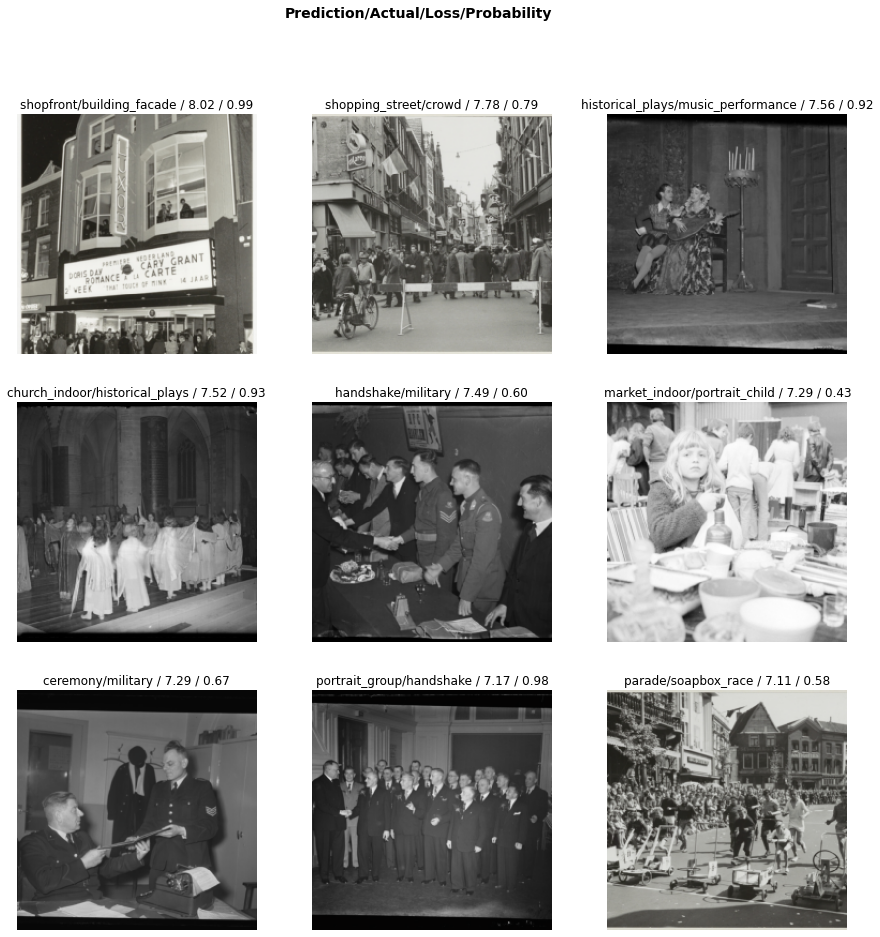

In [377]:
fig = interp.plot_top_losses(9, figsize=(15,15))
plt.savefig('top_losses.png', bbox_inches='tight')

In [369]:
interp.print_classification_report()

                          precision    recall  f1-score   support

            accident_car       0.90      0.45      0.60        20
      accident_stretcher       0.00      0.00      0.00         6
          accident_train       0.67      0.89      0.76         9
                  aerial       0.88      0.88      0.88         8
            amphitheater       0.50      1.00      0.67         1
             animals_cow       1.00      0.50      0.67         6
             animals_dog       1.00      0.20      0.33         5
           animals_horse       0.67      0.57      0.62        21
            animals_misc       0.83      0.71      0.77        21
                 artwork       0.88      0.78      0.82         9
              auditorium       0.35      0.73      0.47        11
                  bakery       0.50      0.11      0.18         9
                     bar       0.50      0.50      0.50        10
                baseball       0.80      0.89      0.84         9
         

In [36]:
interp.most_confused(min_val=5)

[('ceremony', 'handshake', 9),
 ('handshake', 'ceremony', 9),
 ('portrait_children', 'portrait_group', 7),
 ('residential_neighborhood', 'street', 6),
 ('harbor', 'boats', 5),
 ('portrait_group', 'ceremony', 5)]